In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import pymorphy2
import math
from matplotlib.ticker import MultipleLocator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
import csv
import re
import requests
import json
from bs4 import BeautifulSoup

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"
}

URL_TEMPLATE = "https://www.banki.ru/services/responses/bank/promsvyazbank/?page={page_index}&is_countable=on"

def clean_comment_text(text: str) -> str:
    """
    Clean up the text of the comment by removing unwanted characters.
    """
    return re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9\s.,?!\-:;()]+", "", text)

def get_comments(page_index: int):
    url = URL_TEMPLATE.format(page_index=page_index)

    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching page {page_index}: {e}")
        return []

    # Parse the HTML page
    soup = BeautifulSoup(response.text, "html.parser")

    # Look for the JSON data embedded in a script tag
    script_tag = soup.find("script", {"type": "application/ld+json"})

    if script_tag:
        try:
            data = (
                script_tag.string.strip()
                .replace("&quot;", "")
                .replace("&lt;p&gt;", "")
                .replace("&lt;/p&gt;", "")
                .replace("\u00A0", "")
            )
            data = re.sub(r'\\[^"\\/bfnrtu]', "", data)
            data = json.loads(data)

            reviews = data.get("review", [])
            if not reviews:
                print(f"No reviews found on page {page_index}.")
                return []

            # Extract the required fields
            result = []
            for record in reviews:
                comment = clean_comment_text(record.get("description", ""))
                date_published = record.get("datePublished", "N/A")
                best_rating = record.get("reviewRating", {}).get("ratingValue", "N/A")
                result.append((comment, date_published, best_rating))

            return result

        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error parsing JSON on page {page_index}: {e}")
            return []
    else:
        print(f"Script tag with JSON not found on page {page_index}.")
        return []


def save_comments_to_csv(comments, filename="comments.csv"):
    with open(filename, mode="a", encoding="utf-8", newline="") as file:
        writer = csv.writer(file)
        for comment, date_published, best_rating in comments:
            writer.writerow([comment, date_published, best_rating])


def main():
    page_index = 1
    output_file = "comments.csv"

    # Write header row to the CSV file
    with open(output_file, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Comment", "DatePublished", "ratingValue"])

    while page_index <= 450:
        comments = get_comments(page_index)
        if not comments:
            break
        print(f"Page {page_index} comments: {len(comments)} found.")
        save_comments_to_csv(comments, output_file)
        page_index += 1
    main()

In [3]:
df = pd.read_csv('comments.csv')

In [4]:
def map_values(val):
    if val >= 4:
        return 2
    elif val >= 2 and val < 4:
        return 1
    else:
        return 0
df['rating_value'] = df['ratingValue'].apply(map_values)
df['text'] = df['Comment']
df['comment_date'] = pd.to_datetime(df['DatePublished']).dt.date
df = df[['text', 'rating_value', 'comment_date']]
df

,text,rating_value,comment_date
0,"Давно хотела открыть брокерский счет, узнать к...",2,2024-05-16
1,Открыла счет в банке в марте. За два месяца ош...,0,2024-05-16
2,Мой работодатель в апреле оформил мне зарплат ...,0,2024-05-15
3,"Не начислился кешбек за месяц,обратился в час ...",2,2024-05-15
4,Я рад поделиться своим отзывом о банке ПСБ. Хо...,2,2024-05-14
...,...,...,...
6655,"К ПСБ-онлайн никаких претензий: удобно, быстро...",1,2005-06-17
6656,"Угу, все хорошо, все замечательно у них... И п...",1,2005-06-03
6657,"Все нравится, PSB-online просто супер!\r\n\r\n...",2,2005-05-26
6658,Полностью согласна со мнением xKing-а. Очень у...,2,2005-05-25


In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()
def preprocess_text(text):
    if isinstance(text, float) or pd.isna(text):
        return ''
    elif not isinstance(text, str):
        return str(text) 
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train_data, test_data = train_test_split(
    df,
    test_size=0.2,
    stratify=df['rating_value'],
    random_state=42 
)

In [7]:
train_texts = train_data['text'].tolist()
train_labels = train_data['rating_value'].tolist()
test_texts = test_data['text'].tolist()
test_labels = test_data['rating_value'].tolist()
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)

i m here
herrre
i m here now


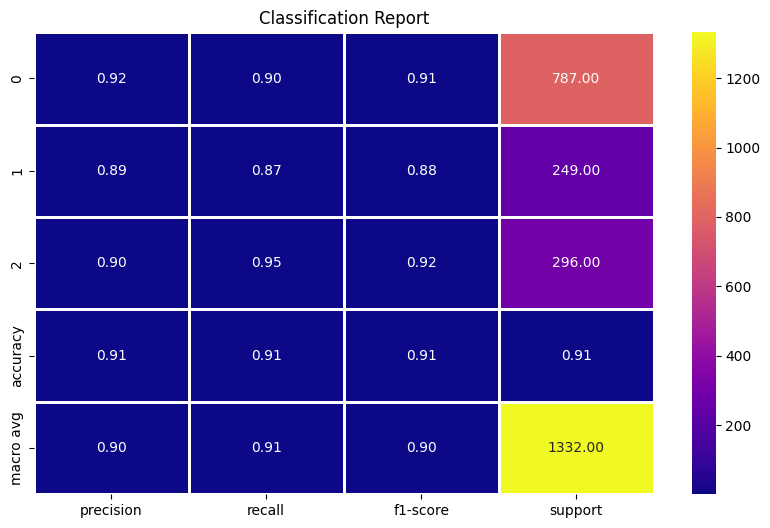

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
report = classification_report(test_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='plasma', fmt=".2f", linewidths=0.8)
plt.title('Classification Report')
plt.show()